# Projet d Analyse et Fouille de donnees "My taylor is rich"
======================================================================================================


Nguyen Philippe  
Nourry Charles

## Solving a classification problem using scikit-learn and keras

The major parts of our projects are:

* Text loading, cleaning and lemmatization
* Word grouping for each level
* Study of word distributions for each class
* Training data with a neural network
* Study of the results


### Importing the libraries needed for this project


In [46]:
from __future__ import division
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas
import seaborn as sea

import keras
import scipy
from sklearn import svm

import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize

from sklearn.preprocessing import StandardScaler

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nourr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nourr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nourr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data loading

We read the data, then we separate it in two parts, a part with the text and an other with the statistics.  
In our project we will focus mainly on the text part, which is much more significant for predicting the level of English.


In [2]:
english = pandas.read_csv("train_cap2018.csv") # Reading data

In [3]:
target = english['level1']
target.head()
print(target.shape)

# data :
data = english.loc[:, "sentences":"Yule's K"]
print(data.shape)

# words_data : 
text = english.loc[:, "fulltext"]
words_data = text.map(lambda t: word_tokenize(t))


(27310,)
(27310, 58)


In [4]:
tagged = nltk.pos_tag(words_data[27304])

print(words_data[27305])

print(len(set(words_data[27305])))

print(len(words_data[27305]))
print(len(set(words_data[27305])) / len(words_data[27305]))
print(len(set(words_data[3000])) / len(words_data[3000]))
print(len(set(words_data[2])) / len(words_data[2]))


def lexical_diversity(text):
    return len(set(text)) / len(text)


ld = words_data.map(lambda t: lexical_diversity(t))



['Hi', 'my', 'name', "'s", 'Jean-Marc', '.', 'I', "'m", 'a', 'management', 'controller', '.', 'I', 'work', 'in', 'an', 'office', '.', 'My', 'favorite', 'day', 'in', 'Sunday', '.', 'I', 'get', 'up', 'at', 'eight', "o'clock", 'in', 'the', 'morning', 'on', 'Sunday', ',', 'have', 'a', 'shower', ',', 'brush', 'my', 'teeth', 'and', 'go', 'running', '.', 'I', 'have', 'lunch', 'at', 'twelve', "o'clock", 'in', 'the', 'afternoon', '.', 'I', 'go', 'swimming', 'in', 'the', 'evening', ',', 'I', 'meet', 'friends', '.', 'We', 'eat', 'in', 'a', 'restaurant', 'then', 'go', 'to', 'the', 'movies', 'and', 'watch', 'a', 'movie', '.', 'I', 'go', 'to', 'bed', 'at', 'eleven', "o'clock", '.']
52
91
0.5714285714285714
0.6238532110091743
0.6938775510204082


### Grouping of data

Data is grouped according to English levels. The words used are very significant to the level of English, a beginner will not use the same words as a bilingual.


In [6]:
# word lists for each instance
pdf = pandas.DataFrame({'level': target, 'words': words_data})

# words grouped according to the level
grouped = pdf.groupby(['level'], sort=False).sum()
grouped

,words
level,
C2,"[The, Eiffel, Tower, is, a, symbol, of, domina..."
C1,"[Since, our, meeting, I, 've, heard, your, req..."
B2,"[At, the, beginning, of, the, metting, the, CE..."
B1,"[Hello, my, friend, ,, I, would, like, to, tel..."
A2,"[Dear, friends, ,, excuse, me, but, I, could, ..."
A1,"[Hello, My, name, 's, David, ., I, 'm, from, F..."


### Lemmatization of words

it is essential to lemmatize the words, in this way we will be able to recognize all the similar words, which have been used in the plural or conjugated in the original data.  
We apply this process twice, once on the data that we grouped by class and another time directly on the instances.


In [7]:
# lemmatization of words
lemmatizer = WordNetLemmatizer()
grouped_in_set = grouped.applymap(lambda l: set(map(lemmatizer.lemmatize, l)))
grouped_in_set

,words
level,
C2,"{Promised, solving, stream, Situated, creature..."
C1,"{amelioration, pollution, joined, tap, client,..."
B2,"{frowning, better.-, meta-genre, pollution, NO..."
B1,"{MCA, 1.each, sap, pollution, Marielle, B.A, j..."
A2,"{Cullen, Smaug, dew, Ile-de-R, Dunkerque, ensl..."
A1,"{amelioration, fourty-seven, Month, pollution,..."


In [8]:
diff_words_count = grouped_in_set.applymap(lambda s: len({w for w in s if w[0].islower()}))
diff_words = grouped_in_set.applymap(lambda s: {w for w in s if w[0].islower()})

In [9]:
# lemmatization of words for every instance
words_lem = words_data.apply(lambda l: set(map(lemmatizer.lemmatize, l)))

In [10]:
diff_words_count["words"]["C2"]

1759

In [11]:
print(len(words_lem[1] & diff_words["words"]["C2"])/len(words_lem[1]))
print(len(words_lem[1] & diff_words["words"]["C1"])/len(words_lem[1]))
print(len(words_lem[1] & diff_words["words"]["B2"])/len(words_lem[1]))
print(len(words_lem[1] & diff_words["words"]["B1"])/len(words_lem[1]))
print(len(words_lem[1] & diff_words["words"]["A2"])/len(words_lem[1]))
print(len(words_lem[1] & diff_words["words"]["A1"])/len(words_lem[1]))

print(len(words_lem[27306] & diff_words["words"]["C2"])/len(words_lem[27306]))
print(len(words_lem[27306] & diff_words["words"]["C1"])/len(words_lem[27306]))
print(len(words_lem[27306] & diff_words["words"]["B2"])/len(words_lem[27306]))
print(len(words_lem[27306] & diff_words["words"]["B1"])/len(words_lem[27306]))
print(len(words_lem[27306] & diff_words["words"]["A2"])/len(words_lem[27306]))
print(len(words_lem[27306] & diff_words["words"]["A1"])/len(words_lem[27306]))

# probabilities of each instance of belonging to each class
dist_C2 = pandas.DataFrame({'C2': words_lem.map(lambda t: len(t & diff_words["words"]["C2"])/len(t)),
                            'C1': words_lem.map(lambda t: len(t & diff_words["words"]["C1"])/len(t)),
                            'B2': words_lem.map(lambda t: len(t & diff_words["words"]["B2"])/len(t)),
                            'B1': words_lem.map(lambda t: len(t & diff_words["words"]["B1"])/len(t)),
                            'A2': words_lem.map(lambda t: len(t & diff_words["words"]["A2"])/len(t)),
                            'A1': words_lem.map(lambda t: len(t & diff_words["words"]["A1"])/len(t)),
                            'level': target
                            })



0.8389830508474576
0.7372881355932204
0.7288135593220338
0.7457627118644068
0.7457627118644068
0.652542372881356
0.5657894736842105
0.6842105263157895
0.7368421052631579
0.7236842105263158
0.7105263157894737
0.8421052631578947


### Histogram of class distribution
This figure shows that the data are not uniformly distributed.


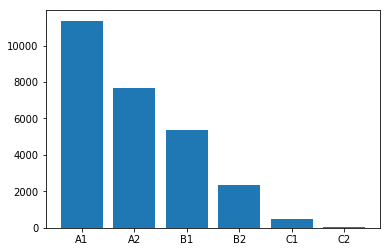

In [12]:
# histogram of class distribution
fig = plt.figure()
y = english.groupby('level1').sentences.count()
plt.bar(y.keys(), y.values)
plt.show()

### Training of a neural network on the data

We use keras to build and train our neural network.  
After processing the data in such a way that we can use them in our neural network. We let the network train for 50 steps.  
This allows us to obtain a validation of accurancy of 86%.



In [13]:
# training of a neural network on the data

import keras.models
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

data_cleaned = english.loc[:, "sentences":"Yule's K"].T.dropna().T
dist = dist_C2.loc[:, "A1":"C2"]

cols = dist.shape[1] + data_cleaned.shape[1]


model = keras.models.Sequential()
model.add(Dense(512, input_shape=(6,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              
              metrics=['accuracy'])

encoder = LabelEncoder()
encoder.fit(dist_C2.loc[:, "level"])

encode_Y = encoder.transform(dist_C2.loc[:, "level"])
Y = np_utils.to_categorical(encode_Y)

# with tf.device('/gpu:0'):

model.fit(dist, Y, epochs=50, batch_size=32) 

# + données du csv

frames = [dist, data_cleaned]

X = pandas.concat(frames, axis=1)

# model.fit(X, Y, epochs=40, batch_size=32) 

Epoch 1/50
27310/27310 [==============================] - 6s 209us/step - loss: 1.2517 - acc: 0.4398
Epoch 2/50
27310/27310 [==============================] - 5s 173us/step - loss: 1.0321 - acc: 0.5461
Epoch 3/50
27310/27310 [==============================] - 4s 161us/step - loss: 0.8931 - acc: 0.6226
Epoch 4/50
27310/27310 [==============================] - 4s 156us/step - loss: 0.7811 - acc: 0.6780
Epoch 5/50
27310/27310 [==============================] - 4s 148us/step - loss: 0.6922 - acc: 0.7190
Epoch 6/50
27310/27310 [==============================] - 4s 155us/step - loss: 0.6306 - acc: 0.7450
Epoch 7/50
27310/27310 [==============================] - 5s 177us/step - loss: 0.5835 - acc: 0.7711
Epoch 8/50
27310/27310 [==============================] - 5s 178us/step - loss: 0.5481 - acc: 0.7848
Epoch 9/50
27310/27310 [==============================] - 6s 202us/step - loss: 0.5215 - acc: 0.7957
Epoch 10/50
27310/27310 [==============================] - 5s 198us/step - loss: 0.5007 - a

### Correlation matrix

We calculate the correlation matrix.


array([[ 1.        ,  0.89395564,  0.88529888, ..., -0.07625987,
        -0.00451134, -0.0470917 ],
       [ 0.89395564,  1.        ,  0.94011045, ..., -0.1648217 ,
        -0.01735999, -0.09274548],
       [ 0.88529888,  0.94011045,  1.        , ..., -0.18962614,
        -0.01508215, -0.12760007],
       ...,
       [-0.07625987, -0.1648217 , -0.18962614, ...,  1.        ,
         0.6858437 , -0.48637956],
       [-0.00451134, -0.01735999, -0.01508215, ...,  0.6858437 ,
         1.        , -0.5895272 ],
       [-0.0470917 , -0.09274548, -0.12760007, ..., -0.48637956,
        -0.5895272 ,  1.        ]])

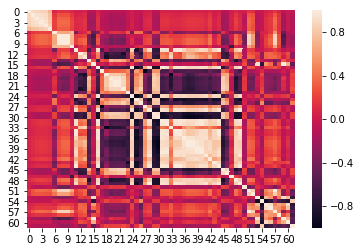

In [45]:
# study of the correlation of the data with the correlation matrix

data_standard = StandardScaler().fit_transform(X)
corr = np.corrcoef(data_standard.T)
corr.shape


sea.heatmap(corr)
corr


### Confusion matrix

The confusion matrix is calculated from the data whose level of English is known.  
We compare the classes of the data with the results predicted by our model.




In [43]:
# confusion matrix
import random
from sklearn.metrics import confusion_matrix

y_true = dist_C2.loc[:, "level"]
y_predict = model.predict(dist_C2.loc[:, "A1":"C2"], batch_size=32)
y_pred = []
level = ["A1", "A2", "B1", "B2", "C1", "C2"]

for i in range (0,np.shape(y_predict)[0]):
    max = np.max(y_predict[i])
    pos, = np.where(y_predict[i] == max)
    y_pred.append(level[pos[random.randint(0,len(pos)-1)]])

cm = confusion_matrix(y_true, y_pred, labels=["A1", "A2", "B1", "B2", "C1", "C2"])
cm

array([[11361,     0,     0,     0,     0,     0],
       [ 1613,  5983,     0,    92,     0,     0],
       [  607,   319,  4097,   352,     8,     0],
       [   56,    21,     0,  2260,     0,     0],
       [   24,     6,     2,    27,   432,     0],
       [    1,     5,    13,    11,     0,    20]], dtype=int64)

In [13]:
from sklearn.model_selection import cross_val_score
%time listerr = cross_val_score(clf, dist_C2, target, cv=5)


NameError: name 'clf' is not defined